In [1]:
%matplotlib inline


In [1]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

import matplotlib.pyplot as plt
plt.close("all")


In [2]:
!pip install imagehash -q

In [3]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter, defaultdict
from PIL import Image
import imagehash


In [5]:
ROOT = r"E:\projects\TrainingFPDModel\End-to-End-DL-Pipeline2\datasets\FURNITURE_DETECTION.v1"
IMAGES_DIR = os.path.join(ROOT, "train/images")
LABELS_DIR = os.path.join(ROOT, "train/labels")
DATA_YAML = os.path.join(ROOT, "data.yaml")


In [23]:
with open(DATA_YAML, "r") as f:
    cfg = yaml.safe_load(f)

names = cfg["names"]
nc = len(names)

print(f"Classes ({nc}):")
for i, n in enumerate(names):
    print(i, "→", n)


Classes (28):
0 → single door
1 → double door
2 → sliding door
3 → window
4 → bay window
5 → blind window
6 → opening symbol
7 → stair
8 → gas stove
9 → refrigerator
10 → washing machine
11 → sofa
12 → bed
13 → chair
14 → table
15 → bedside cupboard
16 → TV cabinet
17 → half-height cabinet
18 → high cabinet
19 → wardrobe
20 → sink
21 → bath
22 → bath tub
23 → squat toilet
24 → urinal
25 → toilet
26 → elevator
27 → escalator


In [24]:
class_counts = Counter()
objects_per_image = []
box_areas = []
invalid_labels = 0
empty_images = 0

image_hashes = defaultdict(list)


In [25]:
image_files = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(".png")]

for img_name in tqdm(image_files):
    img_path = os.path.join(IMAGES_DIR, img_name)
    lbl_path = os.path.join(LABELS_DIR, img_name.replace(".png", ".txt"))

    # ---------- Duplicate detection ----------
    img = Image.open(img_path).convert("RGB")
    ph = imagehash.phash(img)
    image_hashes[str(ph)].append(img_path)

    # ---------- Labels ----------
    if not os.path.exists(lbl_path):
        objects_per_image.append(0)
        empty_images += 1
        continue

    with open(lbl_path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]

    objects_per_image.append(len(lines))

    for line in lines:
        try:
            cls, xc, yc, w, h = map(float, line.split())
            cls = int(cls)

            if cls < 0 or cls >= nc or w <= 0 or h <= 0:
                invalid_labels += 1
                continue

            class_counts[cls] += 1
            box_areas.append(w * h)

        except:
            invalid_labels += 1


100%|███████████████████████████████████████████████████████████████████████████| 15285/15285 [01:12<00:00, 210.41it/s]


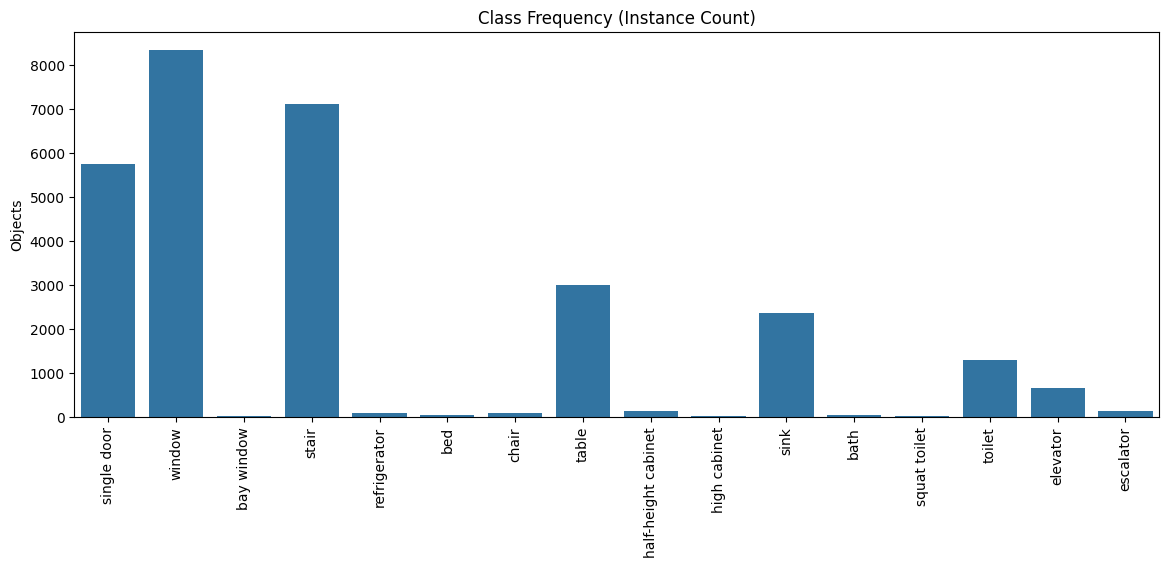

In [26]:
plt.figure(figsize=(14,5))
cls_ids = sorted(class_counts.keys())
counts = [class_counts[c] for c in cls_ids]

sns.barplot(x=[names[c] for c in cls_ids], y=counts)
plt.xticks(rotation=90)
plt.title("Class Frequency (Instance Count)")
plt.ylabel("Objects")
plt.show()


In [27]:
counts_arr = np.array(counts)
max_c, min_c = counts_arr.max(), counts_arr.min()

print(f"Max / Min class ratio = {max_c / min_c:.2f}")

if max_c / min_c > 10:
    print("❌ Severe class imbalance")
elif max_c / min_c > 3:
    print("⚠ Mild imbalance")
else:
    print("✓ Acceptable balance")


Max / Min class ratio = 4166.50
❌ Severe class imbalance


In [28]:
print("Number of classes with annotations:", len(class_counts))
print("Raw class_counts:")
for k, v in class_counts.items():
    print(k, names[k], v)


Number of classes with annotations: 16
Raw class_counts:
14 table 2994
3 window 8333
0 single door 5736
7 stair 7096
20 sink 2355
25 toilet 1276
9 refrigerator 83
26 elevator 649
21 bath 34
17 half-height cabinet 123
13 chair 73
27 escalator 116
12 bed 24
18 high cabinet 8
4 bay window 4
23 squat toilet 2


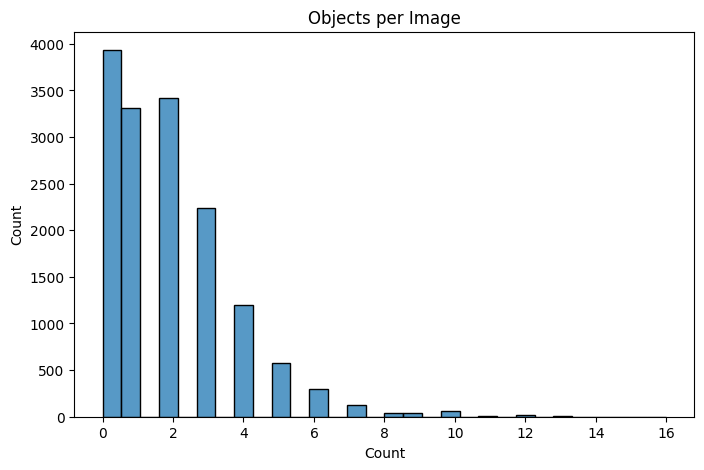

In [29]:
plt.figure(figsize=(8,5))
sns.histplot(objects_per_image, bins=30)
plt.title("Objects per Image")
plt.xlabel("Count")
plt.show()


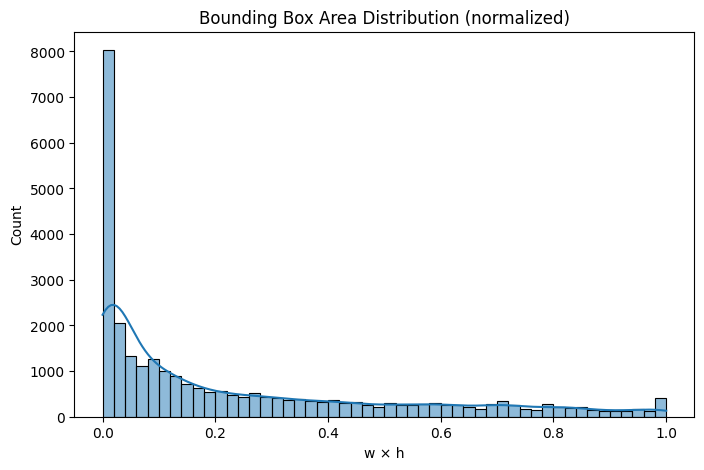

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(box_areas, bins=50, kde=True)
plt.title("Bounding Box Area Distribution (normalized)")
plt.xlabel("w × h")
plt.show()


In [31]:
print("Total images:", len(image_files))
print("Images with no annotations:", empty_images)
print("Invalid label entries:", invalid_labels)
print("Avg objects per image:", np.mean(objects_per_image))


Total images: 15285
Images with no annotations: 0
Invalid label entries: 0
Avg objects per image: 1.8911350997710172


In [32]:
duplicates = {h: paths for h, paths in image_hashes.items() if len(paths) > 1}

print(f"Duplicate groups found: {len(duplicates)}")

for h, paths in list(duplicates.items())[:5]:
    print("\nDuplicate group:")
    for p in paths:
        print(p)


Duplicate groups found: 1219

Duplicate group:
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0000-0002.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0004-0002.png

Duplicate group:
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0004-0001.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0027-0001.png

Duplicate group:
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0004-0004.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0027-0004.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0061-0004.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0130-0004.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0907-0004.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\0960-0004.png
E:\projects\TrainingFPDModel\datasets\FloorPlanCAD_YOLOv8_Full\images\1179-00

In [33]:
print("\n--- DATASET HEALTH SUMMARY ---")

if max_c / min_c > 10:
    print("• Severe class imbalance")
if empty_images > 0:
    print("• Empty images present")
if invalid_labels > 0:
    print("• Invalid annotations detected")
if len(duplicates) > 0:
    print("• Duplicate images detected")
if np.mean(objects_per_image) < 3:
    print("• Very sparse annotations")

print("Review above issues before training.")



--- DATASET HEALTH SUMMARY ---
• Severe class imbalance
• Duplicate images detected
• Very sparse annotations
Review above issues before training.


In [36]:
print("Total images scanned:", len(image_files))
print("Total objects:", sum(class_counts.values()))
print("Classes (defined in yaml):", nc)
print("Classes with annotations:", len(class_counts))
print("Avg objects per image:", np.mean(objects_per_image))
print("Images with zero objects:", objects_per_image.count(0))


Total images scanned: 15285
Total objects: 28906
Classes (defined in yaml): 28
Classes with annotations: 16
Avg objects per image: 1.8911350997710172
Images with zero objects: 3933


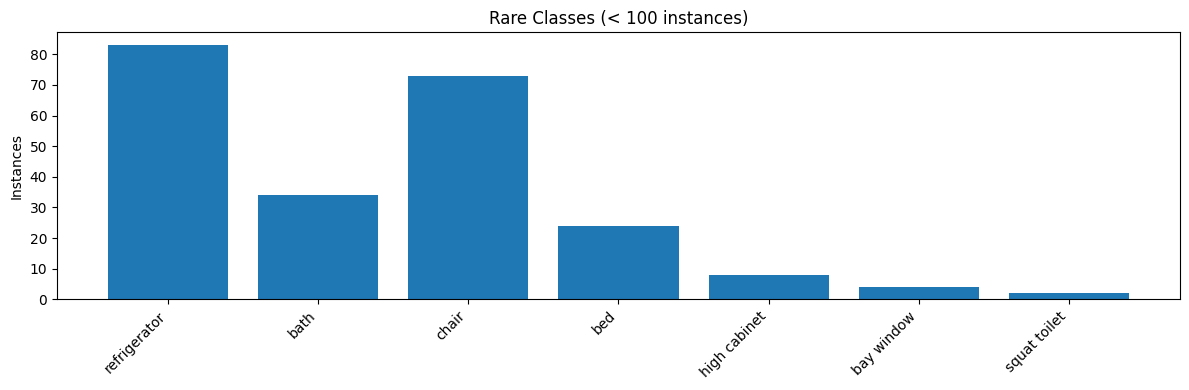

In [19]:
rare_threshold = 100
rare_classes = [(c, v) for c, v in class_counts.items() if v < rare_threshold]

plt.figure(figsize=(12,4))
plt.bar(
    [names[c] for c, _ in rare_classes],
    [v for _, v in rare_classes]
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Instances")
plt.title(f"Rare Classes (< {rare_threshold} instances)")
plt.tight_layout()
plt.show()
